<a href="https://colab.research.google.com/github/Merionm/Stock2Morrow-Course/blob/master/Resampling_Timeframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Timeframe Condition Base


จากคำถาม https://www.facebook.com/groups/850452402079768/permalink/881732045618470/

From : Zacky Zane
รบกวนสอบถามอาจารย์ครับ
กรณีเทรด TFex แบบมีเงื่อนไข 2 Time Frame เช่น
ใน Day ให้ราคาอยู่เหนือ MA 50 ขึ้นไป
ใน time frame 1 ชั่วโมงราคา ตัด RSI ขึ้นผ่านที่ 30
เมื่อผ่าน 2 เงื่อนไขนี้ เราถึงเข้าซื้อ
อะไรประมาณนี้
ด้านข้อมูล และการเขียน Code พอจะมีตัวอย่างมั้ยครับผม  
ขอบคุณครับ 🙂🙂🙂

In [0]:
import numpy as np
import pandas as pd
import ta
import datetime
import DeeperTradeLibrary as dpt

## Function for Resampling Timeframe

In [0]:
def timeframe_resampler(dt):
  if dt.name == 'open' and bool(len(dt)):
    return dt.values[0]
  elif dt.name == 'high':
    return dt.max()
  elif dt.name == 'low':
    return dt.min()
  elif dt.name == 'close' and bool(len(dt)):
    return dt.values[-1]
  elif dt.name == 'volume':
    return dt.sum()

In [3]:
#โหลดไฟล์ csv และทำการเปลี่ยนชื่อ Columns เป็นรูปแบบมาตรฐาน คือ time,open,high,low,close แบบตัวเล็กทั้งหมด แล้วจึงกำหนดให้ time เป็น index และ drop ตัว column ที่ชื่อ complete ทิ้งเนื่องจากไม่ได้ใช้
url = 'https://raw.githubusercontent.com/Merionm/Stock2Morrow-Course/master/Example%20Data/S50IF_CONOI_H1.csv'
df_H1 = pd.read_csv(url)
df_H1.columns = [x.lower() for x in df_H1.columns]
df_H1['time'] = pd.to_datetime(df_H1['time'])
df_H1 = df_H1.drop('complete', axis=1).set_index('time')
df_H1.head()

,open,high,low,close,volume
time,,,,,
2006-04-28 09:00:00,536.5,542.0,536.5,536.5,18
2006-04-28 10:00:00,536.0,536.5,535.6,536.0,18
2006-04-28 11:00:00,536.2,537.5,536.0,536.5,10
2006-04-28 12:00:00,537.0,537.1,537.0,537.1,2
2006-04-28 14:00:00,537.0,537.2,537.0,537.0,13


In [4]:
#ทำการสร้าง Timeframe ใหม่ จากข้อมูล TimeFrame รายชั่วโมงโดยใช้คำสั่ง resample และใช้ฟังก์ชั่น timeframe_resampler ที่เขียนไว้ให้ข้างต้น
df_D1 = df_H1.resample('1D').apply(timeframe_resampler).dropna()
df_D1.head(5)

,open,high,low,close,volume
time,,,,,
2006-04-28,536.5,542.0,535.6,536.2,152
2006-05-02,536.0,537.2,536.0,536.1,53
2006-05-03,537.0,538.5,537.0,538.5,75
2006-05-04,536.8,536.8,535.6,535.7,81
2006-05-08,536.5,542.0,536.5,541.0,109


In [0]:
#สร้าง DataFrame ใหม่สำหรับการประมวลผลเพื่อที่จะไม่กระทบข้อมูลหลัก
df_trade = df_H1.copy()
#สร้างเส้นค่าเฉลี่ย 50 รายวัน และทำการขยับข้อมูลลงไป 1 วัน เนื่องจากเราระบุให้ใช้ช่อง close นั้นหมายความว่าเราได้เส้น ณ ตลาดปิด จะได้ให้เกิดอาการ Data Leak หรือข้อมูลอนาคตรั่วไหลไปในระบบเทรดได้ เราจึงจำเป็นต้องขยับย้อนหลังไป 1 วันโดยใช้ราคาปิดวันก่อนแทน
df_D1['sma50'] = df_D1['close'].rolling(50).mean().shift(1)
#แล้วจึง dropna ทิ้ง
df_D1.dropna(inplace=True)
#สร้างเส้น rsi รายชั่วโมง
df_trade['rsi14'] = ta.momentum.rsi(df_trade['close'], n=14)

In [6]:
#จริงๆ แล้ว เราสามารถเติมเส้นค่าเฉลี่ยจาก TimeFrame อื่นๆ เข้าไปได้ตรงๆ เลย แต่เนื่องด้วยตลาด TFEX ไม่ได้เปิด 24 ชั่วโมง แต่ข้อมูลวันสำหรับ Python จะถือว่าเป็นเวลา 00:00
#เราจึงไม่สามารถเติมเข้าไปตรงๆ ได้ โดยผมจะใช้วิธีการ Adjust Time ใหม่แทนให้ตรงกับแท่งชั่วโมง ซึ่งคือ 09:00:00
df_D1['time_adjust'] = df_D1.index + datetime.timedelta(hours=9)
df_D1.head()

,open,high,low,close,volume,sma50,time_adjust
time,,,,,,,
2006-07-17,450.1,450.1,446.5,448.0,902,489.178,2006-07-17 09:00:00
2006-07-18,449.5,453.2,449.0,451.7,997,487.414,2006-07-18 09:00:00
2006-07-19,453.2,454.7,448.8,451.7,1049,485.726,2006-07-19 09:00:00
2006-07-20,459.2,460.7,457.5,459.1,1037,483.990,2006-07-20 09:00:00
2006-07-21,455.0,471.0,455.0,471.0,1745,482.458,2006-07-21 09:00:00


In [7]:
#ตั้ง time_adjust เป็น index ใหม่
df_D1.set_index('time_adjust', inplace=True)
df_D1.head()

,open,high,low,close,volume,sma50
time_adjust,,,,,,
2006-07-17 09:00:00,450.1,450.1,446.5,448.0,902,489.178
2006-07-18 09:00:00,449.5,453.2,449.0,451.7,997,487.414
2006-07-19 09:00:00,453.2,454.7,448.8,451.7,1049,485.726
2006-07-20 09:00:00,459.2,460.7,457.5,459.1,1037,483.990
2006-07-21 09:00:00,455.0,471.0,455.0,471.0,1745,482.458


In [8]:
#ทำการเพิ่มช่องค่าเฉลี่ยโดยใช้ข้อมูลจาก df_D1
df_trade['sma50_D1'] = df_D1['sma50']
df_trade.dropna(inplace=True)
df_trade.head()

,open,high,low,close,volume,rsi14,sma50_D1
time,,,,,,,
2006-07-17 09:00:00,450.1,450.1,448.8,449.0,141,24.742652,489.178
2006-07-18 09:00:00,449.5,452.0,449.5,450.5,70,34.840709,487.414
2006-07-19 09:00:00,453.2,454.6,453.2,454.5,146,48.924276,485.726
2006-07-20 09:00:00,459.2,460.7,459.2,460.5,239,63.193805,483.990
2006-07-21 09:00:00,455.0,456.5,455.0,456.0,130,49.902521,482.458


In [0]:
#หาจุดเข้า โดยกำหนดให้ rsi แท่งก่อนหน้าน้อยกว่า 30 และแท่งปัจจุบันมากกว่า 50 ซึ่งคือจดตัดการซื้อขาย และราคาปัจจุบันมากกว่า sma50_D1
df_trade['entry'] = (df_trade['rsi14'].shift(1) < 30) & (df_trade['rsi14'] >= 30) & (df_trade['close'] > df_trade['sma50_D1'])

In [10]:
#ทำการเปลี่ยนข้อมูลที่ไม่ใช่จุดเข้า แล้วจึงเติมด้วย NaN
df_trade['entry'].replace(False, np.nan)

time
2006-07-17 09:00:00   NaN
2006-07-18 09:00:00   NaN
2006-07-19 09:00:00   NaN
2006-07-20 09:00:00   NaN
2006-07-21 09:00:00   NaN
                       ..
2018-12-24 09:00:00   NaN
2018-12-25 09:00:00   NaN
2018-12-26 09:00:00   NaN
2018-12-27 09:00:00   NaN
2018-12-28 09:00:00   NaN
Name: entry, Length: 3042, dtype: float64

In [0]:
#หาจุดออกเช่นเดียวกับจุดเข้า คือ rsi แท่งก่อนหน้าน้อยกว่า 70 และแท่งปัจจุบันมากกว่า 70 หรือ ราคาปิดปัจจุบันน้อยกว่า sma50_D1
df_trade['exit'] = (df_trade['rsi14'].shift(1) < 70) & (df_trade['rsi14'] >= 70) | (df_trade['close'] < df_trade['sma50_D1'])

In [12]:
#ทำการเปลี่ยนข้อมูลที่เป็นไม่ใช่จุดออกเป็น NaN
(df_trade['exit'] == False).replace(True, np.nan)

time
2006-07-17 09:00:00    0.0
2006-07-18 09:00:00    0.0
2006-07-19 09:00:00    0.0
2006-07-20 09:00:00    0.0
2006-07-21 09:00:00    0.0
                      ... 
2018-12-24 09:00:00    0.0
2018-12-25 09:00:00    0.0
2018-12-26 09:00:00    0.0
2018-12-27 09:00:00    0.0
2018-12-28 09:00:00    0.0
Name: exit, Length: 3042, dtype: float64

In [0]:
#นำค่า entry ไปใส่ signal แต่ใส่เฉพาะค่าที่เป็น True(จุดเข้า)
df_trade['signal'] = df_trade.loc[df_trade['entry']==True, 'entry']

In [0]:
#นำค่า exit ไปใส่ signal แต่ใส่เฉพาะค่าที่เป็น True(จุดเข้า)
df_trade.loc[df_trade['exit']==True, 'signal'] = False

In [0]:
#ทำการ Fill forward เพื่อเติม nan แทนที่สัญญาณข้างหน้า
df_trade['signal'] = df_trade['signal'].ffill()
#ในบางกรณีจะมี NaN ที่ Row แรกๆ จึงควรจะทำการ fillna ทั้งหมดไปด้วย
df_trade.fillna(value=False, inplace=True)

In [16]:
#ได้ Dataframe ที่พร้อมใช้งาน
df_trade.head(50)

,open,high,low,close,volume,rsi14,sma50_D1,entry,exit,signal
time,,,,,,,,,,
2006-07-17 09:00:00,450.1,450.1,448.8,449.0,141,24.742652,489.178,False,True,False
2006-07-18 09:00:00,449.5,452.0,449.5,450.5,70,34.840709,487.414,False,True,False
2006-07-19 09:00:00,453.2,454.6,453.2,454.5,146,48.924276,485.726,False,True,False
2006-07-20 09:00:00,459.2,460.7,459.2,460.5,239,63.193805,483.990,False,True,False
2006-07-21 09:00:00,455.0,456.5,455.0,456.0,130,49.902521,482.458,False,True,False
2006-07-24 09:00:00,471.5,471.5,468.0,468.8,32,66.943924,481.058,False,True,False
2006-07-25 09:00:00,479.9,480.0,477.5,478.7,147,73.746799,479.650,False,True,False
2006-07-26 09:00:00,475.0,476.2,475.0,476.2,43,64.243015,478.286,False,True,False
2006-07-27 09:00:00,478.6,478.8,478.3,478.3,40,65.572277,476.952,False,False,False


In [17]:
df_trade['time'] = df_trade.index
df_trade.head()

,open,high,low,close,volume,rsi14,sma50_D1,entry,exit,signal,time
time,,,,,,,,,,,
2006-07-17 09:00:00,450.1,450.1,448.8,449.0,141,24.742652,489.178,False,True,False,2006-07-17 09:00:00
2006-07-18 09:00:00,449.5,452.0,449.5,450.5,70,34.840709,487.414,False,True,False,2006-07-18 09:00:00
2006-07-19 09:00:00,453.2,454.6,453.2,454.5,146,48.924276,485.726,False,True,False,2006-07-19 09:00:00
2006-07-20 09:00:00,459.2,460.7,459.2,460.5,239,63.193805,483.990,False,True,False,2006-07-20 09:00:00
2006-07-21 09:00:00,455.0,456.5,455.0,456.0,130,49.902521,482.458,False,True,False,2006-07-21 09:00:00


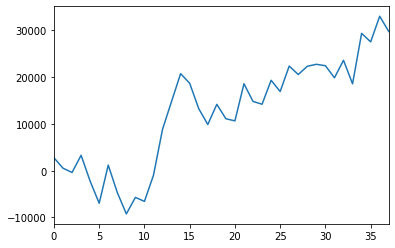

In [18]:
result = dpt.Backtest.trade_simulation(df_trade, digit=1, pip_profit=20, commission=80)
result.equity.plot()